In [1]:
import wget
import zipfile
import pandas as pd # to get the dataframe
import tensorflow as tf # for deep learning
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # for numerical operations
import cv2 # to read or show the image
from sklearn.metrics import accuracy_score # to score our model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator, img_to_array # helpful in getting images
from tensorflow.keras.applications import vgg19 # get the model for image classifier
import joblib
import os
import matplotlib.pyplot as plt
link ='https://dphi-live.s3.eu-west-1.amazonaws.com/dataset/weather.zip' # get the zip file
wget.download(link)

'weather.zip'

In [2]:
with zipfile.ZipFile('./weather.zip', 'r') as zip_ref: # extract the files
    zip_ref.extractall('.')

In [3]:
train_data = pd.read_csv('Training_set.csv') # read the training data
train_data.sample(7)

,filename,label
778,Image_779.jpg,cloudy
671,Image_672.jpg,shine
781,Image_782.jpg,cloudy
65,Image_66.jpg,shine
791,Image_792.jpg,foggy
51,Image_52.jpg,foggy
795,Image_796.jpg,cloudy


In [4]:
train_data.info() # no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1048 non-null   object
 1   label     1048 non-null   object
dtypes: object(2)
memory usage: 16.5+ KB


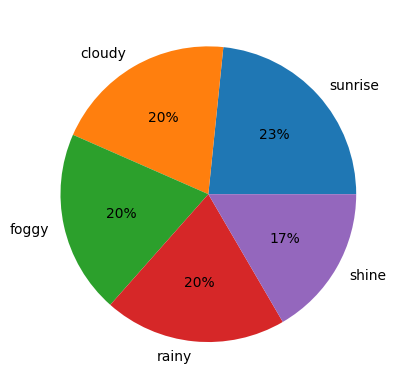

In [5]:
fig_data = np.round(train_data.label.value_counts(normalize=True),4) # get an idea of spread of values
plt.pie(x=fig_data.values, labels=fig_data.index, autopct='%.f%%')
plt.show()

In [4]:
file_paths = [[fname, './train/' + fname] for fname in train_data.filename] # get the paths
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, train_data, on = 'filename')
train_data.sample(7)

,filename,filepaths,label
215,Image_216.jpg,./train/Image_216.jpg,rainy
977,Image_978.jpg,./train/Image_978.jpg,rainy
298,Image_299.jpg,./train/Image_299.jpg,rainy
535,Image_536.jpg,./train/Image_536.jpg,foggy
455,Image_456.jpg,./train/Image_456.jpg,cloudy
968,Image_969.jpg,./train/Image_969.jpg,shine
382,Image_383.jpg,./train/Image_383.jpg,foggy


In [5]:
data_train = []
for i in range(len(train_data)): # get the actual images
  img_array = cv2.imread(train_data['filepaths'][i])
  new_img_array = cv2.resize(img_array, (150, 150)) # resize them for the sake of consistency
  data_train.append(img_to_array(new_img_array)) # append them
# print(data_train[0].shape) # it is list for now
data_train_arr = np.stack(data_train)/255 # make it an array and scale it
# print(data_train_arr.shape)
y = train_data['label']
lb = LabelEncoder()
lb.fit(y)
label_train = lb.transform(y) # get the labels
# print(label_train)

In [8]:
INPUT_SHAPE = (150, 150, 3) # define the input size

vgg_layers = vgg19.VGG19(weights='imagenet', include_top=False,
input_shape=INPUT_SHAPE)
for layer in vgg_layers.layers:
  layer.trainable = True
# define sequential model
model = tf.keras.models.Sequential()
model.add(vgg_layers) # add the vgg19 layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
# compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1

In [9]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
verbose=1, min_delta=0.01, restore_best_weights=True)

history = model.fit(data_train_arr, label_train, batch_size=32,
          callbacks=[es_callback], validation_split=0.3, epochs=50,
          verbose=1)

Epoch 1/50
23/23 [==============================] - 843s 36s/step - loss: 1.4877 - accuracy: 0.3520 - val_loss: 1.0344 - val_accuracy: 0.7746
Epoch 2/50
23/23 [==============================] - 837s 37s/step - loss: 0.7933 - accuracy: 0.7217 - val_loss: 0.4448 - val_accuracy: 0.8286
Epoch 3/50
23/23 [==============================] - 829s 36s/step - loss: 0.4172 - accuracy: 0.8513 - val_loss: 0.2492 - val_accuracy: 0.9111
Epoch 4/50
23/23 [==============================] - 840s 37s/step - loss: 0.2996 - accuracy: 0.8922 - val_loss: 0.2341 - val_accuracy: 0.9111
Epoch 5/50
23/23 [==============================] - 919s 40s/step - loss: 0.1915 - accuracy: 0.9304 - val_loss: 0.2980 - val_accuracy: 0.8762
Epoch 6/50
23/23 [==============================] - 869s 38s/step - loss: 0.1272 - accuracy: 0.9604 - val_loss: 0.2227 - val_accuracy: 0.9333
Epoch 7/50
23/23 [==============================] - 931s 40s/step - loss: 0.1064 - accuracy: 0.9686 - val_loss: 0.2051 - val_accuracy: 0.9333
Epoch 

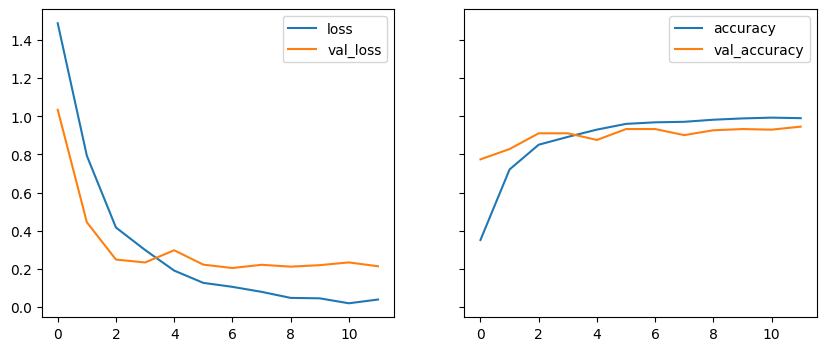

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])
plt.show()

In [ ]:
# joblib.dump(model, 'weather_class_model.joblib', 9)
joblib.dump(lb, 'weather_encoder_model.joblib', 9)
# model.save('weather_class_model.keras', overwrite=True)
os.remove('weather.zip')